# Project 4: Wrangle and Analyze Data

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Gathering](#gathering)
- [Assesing](#Assessing)
- [Cleaning](#Cleaning)
- [Analysis](#Analysis)

<a id='intro'></a>


<a id='gathering'></a>
## Gathering

In [525]:
import tweepy
from tweepy import OAuthHandler
import json
from timeit import default_timer as timer
import pandas as pd
import numpy as np
import requests
import statsmodels.api as sms
import matplotlib.pyplot as plt
import matplotlib.dates as md
from PIL import Image
import wget
import os

### Gather WeRateDogs Twitter Archive Data

In [526]:
df1 = pd.read_csv('twitter-archive-enhanced.csv')

### Gather Tweet Image Predictions Data

In [530]:
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
try:
    response = requests.get(url, allow_redirects=True)
except requests.exceptions.ConnectionError:
    r.status_code = "Connection refused"
    
with open('image_predictions.tsv', mode='wb') as file:
    file.write(response.content)

In [531]:
df_breed = pd.read_csv('image_predictions.tsv', sep='\t')

### Gather Twitter Messages

In [409]:
consumer_key = 'HIDDEN'
consumer_secret = 'HIDDEN'
access_token = 'HIDDEN'
access_secret = 'HIDDEN'

In [410]:
auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

In [411]:
api = tweepy.API(auth, wait_on_rate_limit=True)

In [413]:
tweet_ids = df1.tweet_id.values
len(tweet_ids)

2356

In [15]:
# Query Twitter's API for JSON data for each tweet ID in the Twitter archive
count = 0
fails_dict = {}
start = timer()
# Save each tweet's returned JSON as a new line in a .txt file
with open('tweet_json.txt', 'w') as outfile:
    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
    for tweet_id in tweet_ids:
        count += 1
        print(str(count) + ": " + str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            print("Success")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tweepy.TweepError as e:
            print("Fail")
            fails_dict[tweet_id] = e
            pass
end = timer()
print(end - start)
print(fails_dict)

1: 892420643555336193
Success
2: 892177421306343426
Success
3: 891815181378084864
Success
4: 891689557279858688
Success
5: 891327558926688256
Success
6: 891087950875897856
Success
7: 890971913173991426
Success
8: 890729181411237888
Success
9: 890609185150312448
Success
10: 890240255349198849
Success
11: 890006608113172480
Success
12: 889880896479866881
Success
13: 889665388333682689
Success
14: 889638837579907072
Success
15: 889531135344209921
Success
16: 889278841981685760
Success
17: 888917238123831296
Success
18: 888804989199671297
Success
19: 888554962724278272
Success
20: 888202515573088257
Fail
21: 888078434458587136
Success
22: 887705289381826560
Success
23: 887517139158093824
Success
24: 887473957103951883
Success
25: 887343217045368832
Success
26: 887101392804085760
Success
27: 886983233522544640
Success
28: 886736880519319552
Success
29: 886680336477933568
Success
30: 886366144734445568
Success
31: 886267009285017600
Success
32: 886258384151887873
Success
33: 8860541600590725

262: 842846295480000512
Success
263: 842765311967449089
Success
264: 842535590457499648
Success
265: 842163532590374912
Success
266: 842115215311396866
Success
267: 841833993020538882
Success
268: 841680585030541313
Success
269: 841439858740625411
Success
270: 841320156043304961
Success
271: 841314665196081154
Success
272: 841077006473256960
Success
273: 840761248237133825
Success
274: 840728873075638272
Success
275: 840698636975636481
Success
276: 840696689258311684
Success
277: 840632337062862849
Success
278: 840370681858686976
Success
279: 840268004936019968
Success
280: 839990271299457024
Success
281: 839549326359670784
Success
282: 839290600511926273
Success
283: 839239871831150596
Success
284: 838952994649550848
Success
285: 838921590096166913
Success
286: 838916489579200512
Success
287: 838831947270979586
Success
288: 838561493054533637
Success
289: 838476387338051585
Success
290: 838201503651401729
Success
291: 838150277551247360
Success
292: 838085839343206401
Success
293: 838

Success
519: 810657578271330305
Success
520: 810284430598270976
Success
521: 810254108431155201
Success
522: 809920764300447744
Success
523: 809808892968534016
Success
524: 809448704142938112
Success
525: 809220051211603969
Success
526: 809084759137812480
Success
527: 808838249661788160
Success
528: 808733504066486276
Success
529: 808501579447930884
Success
530: 808344865868283904
Success
531: 808134635716833280
Success
532: 808106460588765185
Success
533: 808001312164028416
Success
534: 807621403335917568
Success
535: 807106840509214720
Success
536: 807059379405148160
Success
537: 807010152071229440
Success
538: 806629075125202948
Success
539: 806620845233815552
Success
540: 806576416489959424
Success
541: 806542213899489280
Success
542: 806242860592926720
Success
543: 806219024703037440
Success
544: 805958939288408065
Success
545: 805932879469572096
Success
546: 805826884734976000
Success
547: 805823200554876929
Success
548: 805520635690676224
Success
549: 805487436403003392
Success


Success
776: 776201521193218049
Success
777: 776113305656188928
Success
778: 776088319444877312
Success
779: 775898661951791106
Success
780: 775842724423557120
Success
781: 775733305207554048
Success
782: 775729183532220416
Success
783: 775364825476165632
Success
784: 775350846108426240
Success
785: 775096608509886464
Fail
786: 775085132600442880
Success
787: 774757898236878852
Success
788: 774639387460112384
Success
789: 774314403806253056
Success
790: 773985732834758656
Success
791: 773922284943896577
Success
792: 773704687002451968
Success
793: 773670353721753600
Success
794: 773547596996571136
Success
795: 773336787167145985
Success
796: 773308824254029826
Success
797: 773247561583001600
Success
798: 773191612633579521
Success
799: 772877495989305348
Success
800: 772826264096874500
Success
801: 772615324260794368
Success
802: 772581559778025472
Success
803: 772193107915964416
Success
804: 772152991789019136
Success
805: 772117678702071809
Success
806: 772114945936949249
Success
807

Success
1032: 745422732645535745
Success
1033: 745314880350101504
Success
1034: 745074613265149952
Success
1035: 745057283344719872
Success
1036: 744995568523612160
Success
1037: 744971049620602880
Success
1038: 744709971296780288
Success
1039: 744334592493166593
Success
1040: 744234799360020481
Success
1041: 744223424764059648
Success
1042: 743980027717509120
Success
1043: 743895849529389061
Success
1044: 743835915802583040
Success
1045: 743609206067040256
Success
1046: 743595368194129920
Success
1047: 743545585370791937
Success
1048: 743510151680958465
Success
1049: 743253157753532416
Success
1050: 743222593470234624
Success
1051: 743210557239623680
Success
1052: 742534281772302336
Success
1053: 742528092657332225
Success
1054: 742465774154047488
Success
1055: 742423170473463808
Success
1056: 742385895052087300
Success
1057: 742161199639494656
Success
1058: 742150209887731712
Success
1059: 741793263812808706
Success
1060: 741743634094141440
Success
1061: 741438259667034112
Success
10

Success
1281: 708834316713893888
Success
1282: 708810915978854401
Success
1283: 708738143638450176
Success
1284: 708711088997666817
Success
1285: 708479650088034305
Success
1286: 708469915515297792
Success
1287: 708400866336894977
Success
1288: 708356463048204288
Success
1289: 708349470027751425
Success
1290: 708149363256774660
Success
1291: 708130923141795840
Success
1292: 708119489313951744
Success
1293: 708109389455101952
Success
1294: 708026248782585858
Success
1295: 707995814724026368
Success
1296: 707983188426153984
Success
1297: 707969809498152960
Success
1298: 707776935007539200
Success
1299: 707741517457260545
Success
1300: 707738799544082433
Success
1301: 707693576495472641
Success
1302: 707629649552134146
Success
1303: 707610948723478529
Success
1304: 707420581654872064
Success
1305: 707411934438625280
Success
1306: 707387676719185920
Success
1307: 707377100785885184
Success
1308: 707315916783140866
Success
1309: 707297311098011648
Success
1310: 707059547140169728
Success
13

Success
1530: 690248561355657216
Success
1531: 690021994562220032
Success
1532: 690015576308211712
Success
1533: 690005060500217858
Success
1534: 689999384604450816
Success
1535: 689993469801164801
Success
1536: 689977555533848577
Success
1537: 689905486972461056
Success
1538: 689877686181715968
Success
1539: 689835978131935233
Success
1540: 689661964914655233
Success
1541: 689659372465688576
Success
1542: 689623661272240129
Success
1543: 689599056876867584
Success
1544: 689557536375177216
Success
1545: 689517482558820352
Success
1546: 689289219123089408
Success
1547: 689283819090870273
Success
1548: 689280876073582592
Success
1549: 689275259254616065
Success
1550: 689255633275777024
Success
1551: 689154315265683456
Success
1552: 689143371370250240
Success
1553: 688916208532455424
Success
1554: 688908934925697024
Success
1555: 688898160958271489
Success
1556: 688894073864884227
Success
1557: 688828561667567616
Success
1558: 688804835492233216
Success
1559: 688789766343622656
Success
15

Success
1779: 677895101218201600
Success
1780: 677716515794329600
Success
1781: 677700003327029250
Success
1782: 677698403548192770
Success
1783: 677687604918272002
Success
1784: 677673981332312066
Success
1785: 677662372920729601
Success
1786: 677644091929329666
Success
1787: 677573743309385728
Success
1788: 677565715327688705
Success
1789: 677557565589463040
Success
1790: 677547928504967168
Success
1791: 677530072887205888
Success
1792: 677335745548390400
Success
1793: 677334615166730240
Success
1794: 677331501395156992
Success
1795: 677328882937298944
Success
1796: 677314812125323265
Success
1797: 677301033169788928
Success
1798: 677269281705472000
Success
1799: 677228873407442944
Success
1800: 677187300187611136
Success
1801: 676975532580409345
Success
1802: 676957860086095872
Fail
1803: 676949632774234114
Success
1804: 676948236477857792
Success
1805: 676946864479084545
Success
1806: 676942428000112642
Success
1807: 676936541936185344
Success
1808: 676916996760600576
Success
1809:

Success
2028: 671874878652489728
Success
2029: 671866342182637568
Success
2030: 671855973984772097
Success
2031: 671789708968640512
Success
2032: 671768281401958400
Success
2033: 671763349865160704
Success
2034: 671744970634719232
Success
2035: 671743150407421952
Success
2036: 671735591348891648
Success
2037: 671729906628341761
Success
2038: 671561002136281088
Success
2039: 671550332464455680
Success
2040: 671547767500775424
Success
2041: 671544874165002241
Success
2042: 671542985629241344
Success
2043: 671538301157904385
Success
2044: 671536543010570240
Success
2045: 671533943490011136
Success
2046: 671528761649688577
Success
2047: 671520732782923777
Success
2048: 671518598289059840
Success
2049: 671511350426865664
Success
2050: 671504605491109889
Success
2051: 671497587707535361
Success
2052: 671488513339211776
Success
2053: 671486386088865792
Success
2054: 671485057807351808
Success
2055: 671390180817915904
Success
2056: 671362598324076544
Success
2057: 671357843010908160
Success
20

Success
2277: 667443425659232256
Success
2278: 667437278097252352
Success
2279: 667435689202614272
Success
2280: 667405339315146752
Success
2281: 667393430834667520
Success
2282: 667369227918143488
Success
2283: 667211855547486208
Success
2284: 667200525029539841
Success
2285: 667192066997374976
Success
2286: 667188689915760640
Success
2287: 667182792070062081
Success
2288: 667177989038297088
Success
2289: 667176164155375616
Success
2290: 667174963120574464
Success
2291: 667171260800061440
Success
2292: 667165590075940865
Success
2293: 667160273090932737
Success
2294: 667152164079423490
Success
2295: 667138269671505920
Success
2296: 667119796878725120
Success
2297: 667090893657276420
Success
2298: 667073648344346624
Success
2299: 667070482143944705
Success
2300: 667065535570550784
Success
2301: 667062181243039745
Success
2302: 667044094246576128
Success
2303: 667012601033924608
Success
2304: 666996132027977728
Success
2305: 666983947667116034
Success
2306: 666837028449972224
Success
23

In [484]:
df2 = pd.read_json('tweet_json.txt', lines=True)

<a id='Assessing'></a>
## Accessing the Data

In [415]:
df1

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None


In [483]:
df_breed

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True


In [485]:
df2

,created_at,id,id_str,full_text,truncated,display_text_range,entities,extended_entities,source,in_reply_to_status_id,...,favorited,retweeted,possibly_sensitive,possibly_sensitive_appealable,lang,retweeted_status,quoted_status_id,quoted_status_id_str,quoted_status_permalink,quoted_status
0,2017-08-01 16:23:56+00:00,892420643555336193,892420643555336192,This is Phineas. He's a mystical boy. Only eve...,False,"[0, 85]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892420639486877696, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
1,2017-08-01 00:17:27+00:00,892177421306343426,892177421306343424,This is Tilly. She's just checking pup on you....,False,"[0, 138]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892177413194625024, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
2,2017-07-31 00:18:03+00:00,891815181378084864,891815181378084864,This is Archie. He is a rare Norwegian Pouncin...,False,"[0, 121]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891815175371796480, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
3,2017-07-30 15:58:51+00:00,891689557279858688,891689557279858688,This is Darla. She commenced a snooze mid meal...,False,"[0, 79]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891689552724799489, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
4,2017-07-29 16:00:24+00:00,891327558926688256,891327558926688256,This is Franklin. He would like you to stop ca...,False,"[0, 138]","{'hashtags': [{'text': 'BarkWeek', 'indices': ...","{'media': [{'id': 891327551943041024, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2323,2015-11-16 00:24:50+00:00,666049248165822465,666049248165822464,Here we have a 1949 1st generation vulpix. Enj...,False,"[0, 120]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 666049244999131136, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
2324,2015-11-16 00:04:52+00:00,666044226329800704,666044226329800704,This is a purebred Piers Morgan. Loves to Netf...,False,"[0, 137]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 666044217047650304, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
2325,2015-11-15 23:21:54+00:00,666033412701032449,666033412701032448,Here is a very happy pup. Big fan of well-main...,False,"[0, 130]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 666033409081393153, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
2326,2015-11-15 23:05:30+00:00,666029285002620928,666029285002620928,This is a western brown Mitsubishi terrier. Up...,False,"[0, 139]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 666029276303482880, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN


#### Accessing Programaticaly

In [33]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [486]:
sum(df1.duplicated())

0

In [487]:
df_breed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [488]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2328 entries, 0 to 2327
Data columns (total 32 columns):
 #   Column                         Non-Null Count  Dtype              
---  ------                         --------------  -----              
 0   created_at                     2328 non-null   datetime64[ns, UTC]
 1   id                             2328 non-null   int64              
 2   id_str                         2328 non-null   int64              
 3   full_text                      2328 non-null   object             
 4   truncated                      2328 non-null   bool               
 5   display_text_range             2328 non-null   object             
 6   entities                       2328 non-null   object             
 7   extended_entities              2057 non-null   object             
 8   source                         2328 non-null   object             
 9   in_reply_to_status_id          77 non-null     float64            
 10  in_reply_to_status_id_st

In [489]:
df2.in_reply_to_status_id.unique()

array([           nan, 8.86266357e+17, 8.81607037e+17, 8.79553827e+17,
       8.70726203e+17, 8.63425646e+17, 6.67152164e+17, 8.57156678e+17,
       8.55818117e+17, 8.55861584e+17, 8.55858536e+17, 8.50328819e+17,
       8.48212112e+17, 8.47606176e+17, 7.59099524e+17, 8.40698300e+17,
       8.38145499e+17, 8.38085539e+17, 8.35245984e+17, 8.32087548e+17,
       8.31903044e+17, 8.26598365e+17, 8.23326389e+17, 8.21152593e+17,
       8.13127252e+17, 8.11627233e+17, 7.33109485e+17, 8.01854331e+17,
       8.00857954e+17, 7.97123751e+17, 7.72743019e+17, 7.66711819e+17,
       7.63865175e+17, 7.50180499e+17, 7.47648654e+17, 7.46885919e+17,
       6.91416866e+17, 7.38411920e+17, 7.29113531e+17, 7.07980066e+17,
       7.03255936e+17, 7.04485745e+17, 7.03041950e+17, 6.96488711e+17,
       6.75349384e+17, 6.70668383e+17, 6.93642232e+17, 6.93572216e+17,
       6.92417313e+17, 6.92041935e+17, 6.90341254e+17, 6.86034025e+17,
       6.85547936e+17, 6.84959799e+17, 6.84481075e+17, 6.84222868e+17,
      

#### Quality Issues
*df1*
- all ID columns are either stored as integers or floats. ID must be stored as strings.               
- timestamp need to be converted to datetime.
- Incorrect dog names in names
- Ratings with decimal values incorrectly extracted

*df_breed*
- Unexpected content in p1, p2, p3 like 'marmot', 'pole', 'laptop', 'basketball', 'tricycle',
convertible', 'limousine', 'orange' etc. 
- mising values. df_breed has only 2075 entries while df1 has 2356.
- Non discriptive column names e.g. p1, p2, etc. 


*df2*
- missing values. Only 2328 entries not 2356.
- two different ID columns with different entries. Not clear which ID matches with the other tabels.
- ID column name ist not consistend with other data.


#### Tidiness Issues
- The columns *doggo, floofer, pupper, puppo, name rating_numerator* and *rating_denominator* fit better to *df_breed*. Thus *df1* forms an observational unit regarding tweet data and *df_breed* an observational unit regarding dog characteristics. 

- doggo, floofer, pupper and puppo are categories of same variable. Therefore need to be melted to one column for tidiness.

<a id='Cleaning'></a>
## Cleaning

In [490]:
df1_clean = df1.copy()
df_breed_clean = df_breed.copy()
df2_clean = df2.copy()

###  Fixing Data Types

#### Define

Change Tweet ID's data type to string and rename ID in df2. 
Changing timestamp to datetime.

#### Code

In [491]:
df2_clean.rename(columns={'id':'tweet_id'}, inplace=True)

In [492]:
df1_clean['tweet_id'] = df1_clean['tweet_id'].astype('str')
df_breed_clean['tweet_id'] = df_breed_clean['tweet_id'].astype('str')
df2_clean['tweet_id'] = df2_clean['tweet_id'].astype('str')

In [493]:
df1_clean['timestamp'] = pd.to_datetime(df1_clean['timestamp'])

#### Test

In [494]:
df2_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2328 entries, 0 to 2327
Data columns (total 32 columns):
 #   Column                         Non-Null Count  Dtype              
---  ------                         --------------  -----              
 0   created_at                     2328 non-null   datetime64[ns, UTC]
 1   tweet_id                       2328 non-null   object             
 2   id_str                         2328 non-null   int64              
 3   full_text                      2328 non-null   object             
 4   truncated                      2328 non-null   bool               
 5   display_text_range             2328 non-null   object             
 6   entities                       2328 non-null   object             
 7   extended_entities              2057 non-null   object             
 8   source                         2328 non-null   object             
 9   in_reply_to_status_id          77 non-null     float64            
 10  in_reply_to_status_id_st

### Dropping Retweets

#### Define

Delete all Retweets.

In [495]:
df2_clean = df2_clean[~df2_clean['full_text'].str.match('RT @')]
df1_clean = df1_clean[~df1_clean['text'].str.match('RT @')]

In [496]:
df1_clean[df1_clean['retweeted_status_id'].notna()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


### Missing Data: Columns *retweet count* and *favorite count* in df1

#### Define

Merging the missing columns from df2 with df1

#### Code

In [497]:
df_twitter = pd.merge(df1_clean, df2_clean[['tweet_id','retweet_count', 'favorite_count']], 
                     on=['tweet_id'], how='right')

#### Test

In [498]:
df_twitter.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2165 entries, 0 to 2164
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    2165 non-null   object             
 1   in_reply_to_status_id       78 non-null     float64            
 2   in_reply_to_user_id         78 non-null     float64            
 3   timestamp                   2165 non-null   datetime64[ns, UTC]
 4   source                      2165 non-null   object             
 5   text                        2165 non-null   object             
 6   retweeted_status_id         0 non-null      float64            
 7   retweeted_status_user_id    0 non-null      float64            
 8   retweeted_status_timestamp  0 non-null      object             
 9   expanded_urls               2107 non-null   object             
 10  rating_numerator            2165 non-null   int64           

### Melting Categoricals 'doggo', 'floofer', 'pupper', 'puppo' into one Column
#### Define

Merging dog characteristics into one table

#### Code

In [499]:
#repalcing 'None' with ''
df_twitter.doggo.replace('None', '', inplace=True)
df_twitter.floofer.replace('None', '', inplace=True)
df_twitter.pupper.replace('None', '', inplace=True)
df_twitter.puppo.replace('None', '', inplace=True)

In [500]:
# Checking for different cases 
df_twitter.groupby(["doggo", "floofer", "pupper", "puppo"]).size().reset_index().rename(columns={0: "count"})

,doggo,floofer,pupper,puppo,count
0,,,,,1823
1,,,,puppo,24
2,,,pupper,,223
3,,floofer,,,9
4,doggo,,,,74
5,doggo,,,puppo,1
6,doggo,,pupper,,10
7,doggo,floofer,,,1


In [501]:
df_twitter['stage'] = df_twitter.doggo + df_twitter.floofer + df_twitter.pupper + df_twitter.puppo
df_twitter.loc[df_twitter.stage == 'doggopupper', 'stage'] = 'doggo, pupper'
df_twitter.loc[df_twitter.stage == 'doggopuppo', 'stage'] = 'doggo, puppo'
df_twitter.loc[df_twitter.stage == 'doggofloofer', 'stage'] = 'doggo, floofer'

#### Test

In [502]:
df_twitter.stage.value_counts()

                  1823
pupper             223
doggo               74
puppo               24
doggo, pupper       10
floofer              9
doggo, puppo         1
doggo, floofer       1
Name: stage, dtype: int64

In [503]:
df_twitter.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,retweet_count,favorite_count,stage
529,790987426131050500,NaN,NaN,2016-10-25 18:44:32+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Misty. She has a cowboy hat on her nos...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/790987426...,12,10,Misty,,,,,2129,9812,
1693,674999807681908736,6.747934e+17,4.196984e+09,2015-12-10 17:11:09+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Ok last one of these. I may try to make some m...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/674999807...,13,10,None,,,,,1045,2125,
598,780192070812196864,NaN,NaN,2016-09-25 23:47:39+00:00,"<a href=""http://twitter.com/download/iphone"" r...",We only rate dogs. Pls stop sending in non-can...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/780192070...,11,10,None,,,,,2217,8654,
2037,668274247790391296,NaN,NaN,2015-11-22 03:46:11+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Meet Sophie. Her son just got in the car to le...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/668274247...,10,10,Sophie,,,,,218,770,
659,770293558247038976,NaN,NaN,2016-08-29 16:14:30+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Jackson. There's nothing abnormal abou...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/770293558...,10,10,Jackson,,,,,1447,6157,


### Dropping Unnessesary Columns

#### Define

Merging dog characteristics into one table

#### Code

In [504]:
df_twitter.drop(['doggo', 'floofer', 'pupper', 'puppo', 'expanded_urls', 'in_reply_to_status_id',
               'in_reply_to_user_id', 'retweeted_status_id', 'retweeted_status_user_id',
               'retweeted_status_timestamp'], axis=1, inplace=True)

#### Test

In [505]:
df_twitter.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2165 entries, 0 to 2164
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2165 non-null   object             
 1   timestamp           2165 non-null   datetime64[ns, UTC]
 2   source              2165 non-null   object             
 3   text                2165 non-null   object             
 4   rating_numerator    2165 non-null   int64              
 5   rating_denominator  2165 non-null   int64              
 6   name                2165 non-null   object             
 7   retweet_count       2165 non-null   int64              
 8   favorite_count      2165 non-null   int64              
 9   stage               2165 non-null   object             
dtypes: datetime64[ns, UTC](1), int64(4), object(5)
memory usage: 186.1+ KB


### Correcting falsely parsed names

#### Define

Dog names which are flasly parsed will be detected by searching lowercase an replaced.

#### Code

In [506]:
# find unreasonable names 
no_names = df_twitter[df_twitter.name.str.islower()].name

In [507]:
# Delete unreasonable names
df_twitter.name.replace(no_names, '', inplace=True)
df_twitter.name.replace('None', '', inplace=True)

#### Test

In [508]:
# The other names seem to be reasonable
df_twitter.name.unique()

array(['Phineas', 'Tilly', 'Archie', 'Darla', 'Franklin', '', 'Jax',
       'Zoey', 'Cassie', 'Koda', 'Bruno', 'Ted', 'Stuart', 'Oliver',
       'Jim', 'Zeke', 'Ralphus', 'Gerald', 'Jeffrey', 'Canela', 'Maya',
       'Mingus', 'Derek', 'Roscoe', 'Waffles', 'Jimbo', 'Maisey', 'Earl',
       'Lola', 'Kevin', 'Yogi', 'Noah', 'Bella', 'Grizzwald', 'Rusty',
       'Gus', 'Stanley', 'Alfy', 'Koko', 'Rey', 'Gary', 'Elliot', 'Louis',
       'Jesse', 'Romeo', 'Bailey', 'Duddles', 'Jack', 'Steven', 'Beau',
       'Snoopy', 'Shadow', 'Emmy', 'Aja', 'Penny', 'Dante', 'Nelly',
       'Ginger', 'Benedict', 'Venti', 'Goose', 'Nugget', 'Cash', 'Jed',
       'Sebastian', 'Sierra', 'Monkey', 'Kody', 'Lassie', 'Rover',
       'Napolean', 'Boomer', 'Cody', 'Rumble', 'Clifford', 'Dewey',
       'Scout', 'Gizmo', 'Walter', 'Cooper', 'Harold', 'Shikha', 'Lili',
       'Jamesy', 'Coco', 'Sammy', 'Meatball', 'Paisley', 'Albus',
       'Neptune', 'Belle', 'Quinn', 'Zooey', 'Dave', 'Jersey', 'Hobbes',
       'Bu

### Find and update incorrect ratings

#### Define

Every denominator which is not equal 10 will be checked wether the parsing was correct.

#### Code

In [453]:
# get index for falty ratings
tweet_id_idx = df_twitter.loc[df_twitter['rating_denominator']!=10, ['tweet_id']].index

In [454]:
# check each text und correct the rating if necessary
df_twitter.loc[tweet_id_idx[0],'text']

"@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho"

In [456]:
df_twitter.loc[tweet_id_idx[0],'rating_nominator']= 13
df_twitter.loc[tweet_id_idx[0],'rating_denominator']= 10

In [357]:
df_twitter.loc[tweet_id_idx[1],'text']

'@docmisterio account started on 11/15/15'

In [358]:
df_twitter.loc[tweet_id_idx[1],'rating_nominator'] = np.NaN
df_twitter.loc[tweet_id_idx[1],'rating_denominator']= np.NaN

In [359]:
df_twitter.loc[tweet_id_idx[2],'text'] # Is correct no need to fix

'The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd'

In [360]:
df_twitter.loc[tweet_id_idx[3],'text']

'Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx'

In [361]:
df_twitter.loc[tweet_id_idx[3],'rating_nominator'] = np.NaN
df_twitter.loc[tweet_id_idx[3],'rating_denominator'] = np.NaN

In [362]:
df_twitter.loc[tweet_id_idx[4],'text'] # Is correct no need to fix

'Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE'

In [363]:
df_twitter.loc[tweet_id_idx[5],'text']

'After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ'

In [364]:
df_twitter.loc[tweet_id_idx[5],'rating_nominator'] = 10
df_twitter.loc[tweet_id_idx[5],'rating_denominator'] = 14

In [365]:
df_twitter.loc[tweet_id_idx[6],'text'] # Is correct no need to fix

'Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv'

In [366]:
df_twitter.loc[tweet_id_idx[7],'text']

'Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a'

In [367]:
df_twitter.loc[tweet_id_idx[7],'rating_nominator'] = 13
df_twitter.loc[tweet_id_idx[7],'rating_denominator'] = 10

In [368]:
df_twitter.loc[tweet_id_idx[8],'text']

'This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq'

In [369]:
df_twitter.loc[tweet_id_idx[8],'rating_nominator'] = 11
df_twitter.loc[tweet_id_idx[8],'rating_denominator'] = 10

In [370]:
df_twitter.loc[tweet_id_idx[9],'text'] # Is correct no need to fix

"Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1"

In [371]:
df_twitter.loc[tweet_id_idx[10],'text']  # Is correct no need to fix

"Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80 https://t.co/0eb7R1Om12"

In [372]:
df_twitter.loc[tweet_id_idx[11],'text']  # Is correct no need to fix

'From left to right:\nCletus, Jerome, Alejandro, Burp, &amp; Titson\nNone know where camera is. 45/50 would hug all at once https://t.co/sedre1ivTK'

In [373]:
df_twitter.loc[tweet_id_idx[12],'text']  # Is correct no need to fix

"Here is a whole flock of puppers.  60/50 I'll take the lot https://t.co/9dpcw6MdWa"

In [374]:
df_twitter.loc[tweet_id_idx[13],'text']  # Is correct no need to fix

"Happy Wednesday here's a bucket of pups. 44/40 would pet all at once https://t.co/HppvrYuamZ"

In [375]:
df_twitter.loc[tweet_id_idx[14],'text'] # Is correct no need to fix

"Yes I do realize a rating of 4/20 would've been fitting. However, it would be unjust to give these cooperative pups that low of a rating"

In [376]:
df_twitter.loc[tweet_id_idx[15],'text']  # Is correct no need to fix

'Two sneaky puppers were not initially seen, moving the rating to 143/130. Please forgive us. Thank you https://t.co/kRK51Y5ac3'

In [377]:
df_twitter.loc[tweet_id_idx[16],'text'] # Is correct no need to fix

'Someone help the girl is being mugged. Several are distracting her while two steal her shoes. Clever puppers 121/110 https://t.co/1zfnTJLt55'

In [378]:
df_twitter.loc[tweet_id_idx[17],'text'] 

'This is Darrel. He just robbed a 7/11 and is in a high speed police chase. Was just spotted by the helicopter 10/10 https://t.co/7EsP8LmSp5'

In [379]:
df_twitter.loc[tweet_id_idx[17],'rating_nominator'] = 10
df_twitter.loc[tweet_id_idx[17],'rating_denominator'] = 10


In [380]:
df_twitter.loc[tweet_id_idx[18],'text']  # Is correct no need to fix

"I'm aware that I could've said 20/16, but here at WeRateDogs we are very professional. An inconsistent rating scale is simply irresponsible"

In [381]:
df_twitter.loc[tweet_id_idx[19],'text']  # Is correct no need to fix

"IT'S PUPPERGEDDON. Total of 144/120 ...I think https://t.co/ZanVtAtvIq"

In [382]:
df_twitter.loc[tweet_id_idx[20],'text']  # Is correct no need to fix

'Here we have an entire platoon of puppers. Total score: 88/80 would pet all at once https://t.co/y93p6FLvVw'

In [383]:
df_twitter.loc[tweet_id_idx[21],'text']

'This is an Albanian 3 1/2 legged  Episcopalian. Loves well-polished hardwood flooring. Penis on the collar. 9/10 https://t.co/d9NcXFKwLv'

In [384]:
df_twitter.loc[tweet_id_idx[21],'rating_nominator'] = 9
df_twitter.loc[tweet_id_idx[21],'rating_denominator'] = 10

#### Test

In [509]:
df_twitter['rating_denominator'].value_counts()

10     2143
50        3
80        2
11        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

###  Renaming not  descriptive columns

#### Define

Renaming columns

#### Code

In [510]:
df_breed_clean.rename(columns={'img_num':'jpg_number', 'p1': 'prediction1', 'p2': 'prediction2',
                              'p3': 'prediction3','p1_conf':'prediction1_confidence',
                              'p2_conf':'prediction2_confidence' ,'p3_conf':'prediction3_confidence',
                              'p1_dog':'prediction1_is_dog','p2_dog':'prediction2_is_dog',
                              'p3_dog':'prediction3_is_dog',}, inplace=True)

#### Test

In [511]:
df_breed_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   tweet_id                2075 non-null   object 
 1   jpg_url                 2075 non-null   object 
 2   jpg_number              2075 non-null   int64  
 3   prediction1             2075 non-null   object 
 4   prediction1_confidence  2075 non-null   float64
 5   prediction1_is_dog      2075 non-null   bool   
 6   prediction2             2075 non-null   object 
 7   prediction2_confidence  2075 non-null   float64
 8   prediction2_is_dog      2075 non-null   bool   
 9   prediction3             2075 non-null   object 
 10  prediction3_confidence  2075 non-null   float64
 11  prediction3_is_dog      2075 non-null   bool   
dtypes: bool(3), float64(3), int64(1), object(5)
memory usage: 152.1+ KB


### Saving Cleaned Datasets


In [512]:
df_twitter.to_csv('df_twitter.csv', index=False)
df_breed_clean.to_csv('df_breed.csv', index=False)

<a id='Analysis'></a>
## Analysis

In this project twitter data from the channel WeRateDogs has been evaluated. The observed Data is from 2015-11 to 2017-08. 

The following Questions will be answered in this work:

**Question 1:** How are the favorite counts and retweets related?

**Question 1:** How did the popularity of the account change over time?

**Question 3:** Which tweets beat the trend?

In order to aswer the first question, the linear regression analysis has been applied. The results indicate as strong linear relation between the favorit counts and the retweets. The analysis also indicate that on avarage every retweet generates **~2.5** favorit counts. 

In [513]:
# perform regression analysis
df_twitter['intercept'] = 1

lm = sms.OLS(df_twitter['favorite_count'], df_twitter[['intercept', 'retweet_count']])
results = lm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         favorite_count   R-squared:                       0.859
Model:                            OLS   Adj. R-squared:                  0.859
Method:                 Least Squares   F-statistic:                 1.314e+04
Date:                Fri, 13 Nov 2020   Prob (F-statistic):               0.00
Time:                        20:11:34   Log-Likelihood:                -21243.
No. Observations:                2165   AIC:                         4.249e+04
Df Residuals:                    2163   BIC:                         4.250e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
intercept      1850.8772    108.932     16.991      0.000    1637.254    2064.500
retweet_count     2.5656      0.022    114.637      0.000       2.522       2.609
==============================================================================
Omnibus:                      603.784   Durbin-Watson:                   0.824
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            15190.091
Skew:                           0.736   Prob(JB):                         0.00
Kurtosis:                      15.893   Cond. No.                     5.58e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.58e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [514]:
# Find start and end date from dataset
df_twitter.timestamp = pd.to_datetime(df_twitter.timestamp )
df_twitter.timestamp.min(), df_twitter.timestamp.max();

In [515]:
# Generate moving average fo retweets and favorit count
window_size = 50
df_twitter['mov_favorite_count'] = df_twitter.favorite_count.rolling(window=window_size).mean()
df_twitter['mov_retweet_count'] = df_twitter.retweet_count.rolling(window=window_size).mean()

For answering the 2nd question, the favorit counts and retweets have been plottet over the time. 

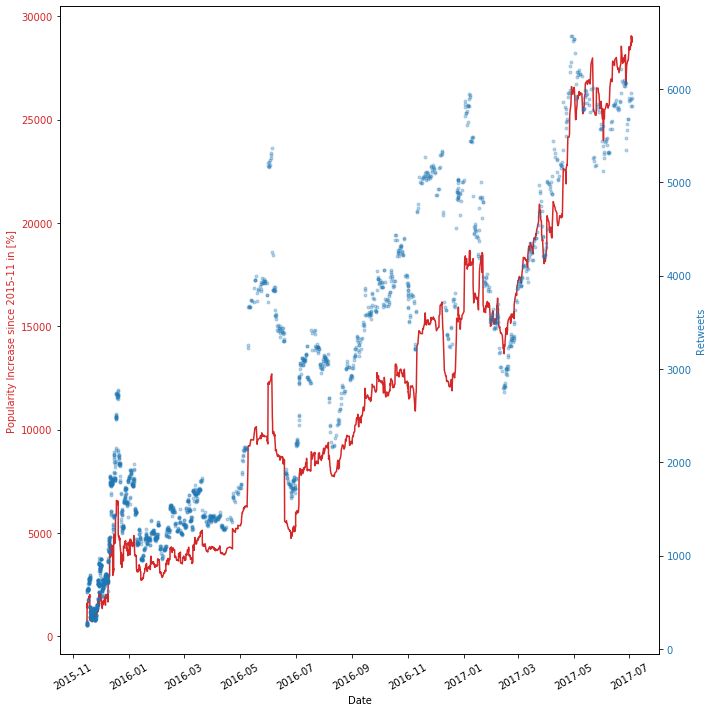

In [516]:
# Plot graph with two axis 
fig, ax = plt.subplots(figsize=(10, 10))


# Relativ depiction of favorit count
color = 'tab:red'
ax.set_xlabel('Date')
ax.set_ylabel('Popularity Increase since 2015-11 in [%]', color=color)
dates = md.date2num(df_twitter.timestamp)
ax.plot_date(dates, df_twitter.mov_favorite_count, ls='-', marker='',  c=color)
ax.tick_params(axis='y', labelcolor=color)
plt.xticks(rotation=30)

# Plot retweets an the 2nd axis
ax2 = ax.twinx()  

color = 'tab:blue'
ax2.set_ylabel('Retweets', color=color)  
ax2.plot_date(dates, df_twitter.mov_retweet_count, ls='', marker='.', c=color, alpha=.3)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  
plt.show()


In this graph, the moving average of the **<font color='red'>favorite count</font>** and the **<font color='blue'>retweets count</font>** has been plotted. To get a better feeling about the strong increase in popularity, the favorite count has been plotted relatively to its starting value at the beginning of the observed period. In the period of just 20 month the popularity increased by roughly factor 25. It is also observable that although the relation between the favorite count and the retweets is a strong linear relationship, the increase in both measures seems to be exponential.  

What led such a success? Are there certain tweets, which may have accelerated the popularity of the account? These questions led me to check the pictures of the top 10 tweets, which beat the trend the most. Of course, the images may not be the only reason for the high numbers in favorite counts and retweets, the context with the message text was also important for sure. However, in my opinion the pictures speak for themselves and make clear high increase in popularity of the account.

In [517]:
# Generate difference
df_twitter['favorite_diff'] = df_twitter.favorite_count - df_twitter.mov_favorite_count

In [518]:
df_breed_clean = pd.merge(df_breed_clean, df_twitter[['tweet_id','favorite_count', 'retweet_count', 'favorite_diff']], 
                     on=['tweet_id'], how='left')

In [519]:
# get only dog pictures
df_dog_pic = df_breed_clean.query('prediction1_is_dog == True and prediction2_is_dog == True and prediction3_is_dog == True')

In [520]:
# sort dof pictures by highest favorite difference
dog_top10 = df_dog_pic.groupby(['tweet_id', 'prediction1', 'prediction2', 'prediction3']).favorite_diff.max()
dog_top10 = dog_top10.sort_values( ascending=False)

In [521]:
# Get only top 10
tweet_id_top10 = dog_top10.index.get_level_values(0)[0:10]

In [522]:
# get url's for top 10 dog pictures
url_list = df_breed_clean.set_index('tweet_id').loc[tweet_id_top10].jpg_url

In [523]:
# donload dog images and rename them with the corrosponding tweet_id 
img_directory = []
for top_tweet in url_list:
    img_name = ''.join(url_list[url_list == top_tweet].index.values.astype('str'))
    output_directory  = os.path.abspath(os.getcwd()) + '\\img_top_10\\' + img_name +'.jpeg'
    img_directory.append(output_directory)
    wget.download(top_tweet, out=output_directory);

100% [..............................................................................] 83286 / 83286

In [524]:
## Code for generating collage from https://stackoverflow.com/questions/35438802/making-a-collage-in-pil


listofimages=img_directory  

width = 200
height = 200

def create_collage(width, height, listofimages):
    cols = 5
    rows = 2
    thumbnail_width = width//cols
    thumbnail_height = height//rows
    size = thumbnail_width, thumbnail_height
    new_im = Image.new('RGB', (width, height))
    ims = []
    for p in listofimages:
        im = Image.open(p)
        im.thumbnail(size)
        ims.append(im)
    i = 0
    x = 0
    y = 0
    for col in range(cols):
        for row in range(rows):
           # print(i, x, y)
            new_im.paste(ims[i], (x, y))
            i += 1;
            y += thumbnail_height
        x += thumbnail_width
        y = 0;

    new_im.save("Collage.jpg")

create_collage(1000, 400, listofimages)

![](Collage.jpg)

*These are the dog pictures of the teets which generted much higher retweets and favorite counts than the trend. Thus, accelerated the popularity of WeRateDogs.*